In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Input,InputLayer,Reshape,GRU,LSTM,Concatenate
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import models,Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D,GlobalAveragePooling2D
import pickle
import numpy as np
from numpy.fft import fft

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Models



1.   LSTM_CNN_SANDWICH
2.   LSTM_CNN
3.   ConvLSTM_PARALLEL
4.   LSTM_CNN_PARALLEL
5.   GRU_CNN
6.   CNN_GRU







In [ ]:
def LSTM_CNN_SANDWICH(input_shape,output_shape):
    #K.set_image_data_format('channels_last')
    n_outputs = output_shape
    input_shape = input_shape
    
    input           = Input(shape=input_shape)
    lstm_1          = Bidirectional(LSTM(32,return_sequences=True))(input)
    activation_1    = Activation("relu")(lstm_1)
    reshape_layer_1 = Reshape((activation_1.shape[1],activation_1.shape[2],1))(activation_1)
    cnn_1           = Conv2D(64, (5,1), strides=(2,1), activation='relu')(reshape_layer_1)
    max_pool_1      = MaxPooling2D((2,1), strides=(2,1))(cnn_1)
    cnn_1_2         = Conv2D(32, (5,1), strides=(2,1), activation='relu')(max_pool_1)
    max_pool_1_2    = MaxPooling2D((2,1), strides=(2,1))(cnn_1_2)
    batch_norm_1    = BatchNormalization()(max_pool_1_2)

    reshape_layer_2 = Reshape((-1,cnn_1.shape[3]))(batch_norm_1)
    lstm_2          = Bidirectional(LSTM(32,return_sequences=True))(reshape_layer_2)
    activation_2    = Activation("relu")(lstm_2)
    reshape_layer_3 = Reshape((activation_2.shape[1],activation_2.shape[2],1))(activation_2)
    cnn_2           = Conv2D(64, (5,1), strides=(2,1), activation='relu')(reshape_layer_3)
    max_pool_2      = MaxPooling2D((2,1), strides=(2,1))(cnn_2)
    cnn_2_2         = Conv2D(32, (5,1), strides=(2,1), activation='relu')(max_pool_2)
    max_pool_2_2    = MaxPooling2D((2,1), strides=(2,1))(cnn_2_2)
    batch_norm_2    = BatchNormalization()(max_pool_2_2)

    global_avg      = GlobalAveragePooling2D()(batch_norm_2)

    dense           = Dense(n_outputs)(global_avg)
    activation_3    = Activation("softmax")(dense)

    model = Model(inputs = input, outputs= activation_3)
    #model.summary()

    rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

    model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m,recall_m])

    return model

In [ ]:
def LSTM_CNN(input_shape=None,n_outputs=None):
    
    #K.set_image_data_format('channels_last')
    n_outputs = n_outputs
    input_shape = input_shape
    input           = Input(shape=input_shape)

    lstm_1          = Bidirectional(LSTM(32,return_sequences=True))(input)
    activation_1    = Activation("relu")(lstm_1)
    lstm_2          = Bidirectional(LSTM(32,return_sequences=True))(activation_1)
    activation_2    = Activation("relu")(lstm_2)

    reshape_layer_1 = Reshape((lstm_2.shape[1],lstm_2.shape[2],1))(activation_2)
    
    cnn_1           = Conv2D(64, (5,5), strides=(2,2), activation='relu')(reshape_layer_1)
    max_pool_1      = MaxPooling2D((2,2), strides=(2,2))(cnn_1)
    cnn_2           = Conv2D(128, (3,3), strides=(1,1), activation='relu')(max_pool_1)
    global_avg      = GlobalAveragePooling2D()(cnn_2)
    dense           = Dense(n_outputs,activation='softmax',kernel_regularizer=keras.regularizers.l2(0.005))(global_avg)

    model = Model(inputs = input, outputs= dense)
    #model.summary()

    rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.001)

    model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m,recall_m])
    
    
    return model

In [ ]:
def ConvLSTM_PARALLEL(input_shape=None,n_outputs=None):
    
    #K.set_image_data_format('channels_last')
    input_shape = input_shape
    input           = Input(shape=input_shape)

    lstm_1          = Bidirectional(LSTM(32,return_sequences=True,activation='relu'))(input)
    activation_1    = Activation("relu")(lstm_1)
    lstm_2          = Bidirectional(LSTM(32,return_sequences=True,activation ='relu'))(activation_1)
    activation_2    = Activation("relu")(lstm_2)
    reshape_layer_1 = Reshape((lstm_2.shape[1],lstm_2.shape[2],1))(activation_2)
    
    cnn_1           = Conv2D(64, (5,5), strides=(2,2), activation='relu')(reshape_layer_1)
    max_pool_1      = MaxPooling2D((2,2), strides=(2,2))(cnn_1)
    cnn_2           = Conv2D(128, (3,3), strides=(1,1), activation='relu')(max_pool_1)
    global_avg      = GlobalAveragePooling2D()(cnn_2)
    flatten         = Flatten()(global_avg)

    reshape_2         = Reshape((input.shape[1],input.shape[2],1))(input)
    cnn_1_2           = Conv2D(64, (5,5), strides=(2,2), activation='relu')(reshape_2)
    #max_pool_1_2     = MaxPooling2D((2,2), strides=(2,2))(cnn_1_2)
    cnn_2_2           = Conv2D(128, (3,3), strides=(1,1), activation='relu')(cnn_1_2)
    global_avg_2      = GlobalAveragePooling2D()(cnn_2_2)

    reshape_layer_1_2 = Reshape((global_avg_2.shape[-1],1))(global_avg_2)
    lstm_1_2          = Bidirectional(LSTM(32,return_sequences=True,activation='relu'))(reshape_layer_1_2)
    activation_1_2    = Activation("relu")(lstm_1_2)
    lstm_2_2          = Bidirectional(LSTM(32,return_sequences=True,activation ='relu'))(activation_1_2)
    activation_2_2    = Activation("relu")(lstm_2_2)
    flatten_2         = Flatten()(activation_2_2)

    concatenate       = Concatenate()([flatten,flatten_2])
    dense             = Dense(n_outputs,activation='softmax',kernel_regularizer=keras.regularizers.l2(0.005))(concatenate)



    model = Model(inputs = input, outputs= dense)
    #model.summary()

    rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

    model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m,recall_m])
    
    
    return model


In [ ]:
def LSTM_CNN_PARALLEL(input_shape=None,n_outputs=None):
    
    #K.set_image_data_format('channels_last')
    input_shape = input_shape
    input           = Input(shape=input_shape)

    lstm_1          = Bidirectional(LSTM(32,return_sequences=True,activation='relu'))(input)
    activation_1    = Activation("relu")(lstm_1)
    lstm_2          = Bidirectional(LSTM(32,return_sequences=True,activation ='relu'))(activation_1)
    activation_2    = Activation("relu")(lstm_2)
    flatten         = Flatten()(activation_2)

    reshape_2         = Reshape((input.shape[1],input.shape[2],1))(input)
    cnn_1_2           = Conv2D(64, (5,5), strides=(2,2), activation='relu')(reshape_2)
    #max_pool_1_2     = MaxPooling2D((2,2), strides=(2,2))(cnn_1_2)
    cnn_2_2           = Conv2D(128, (3,3), strides=(1,1), activation='relu')(cnn_1_2)
    global_avg_2      = GlobalAveragePooling2D()(cnn_2_2)

    flatten_2         = Flatten()(global_avg_2)

    concatenate       = Concatenate()([flatten,flatten_2])
    dense             = Dense(n_outputs,activation='softmax',kernel_regularizer=keras.regularizers.l2(0.005))(concatenate)



    model = Model(inputs = input, outputs= dense)
    #model.summary()

    rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

    model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m,recall_m])
    
    
    return model

In [ ]:
def GRU_CNN(input_shape,output_shape):
    #K.set_image_data_format('channels_last')
    
    n_outputs = output_shape
    input_shape = input_shape
    
    input = Input(shape = input_shape)
    gru_1 = GRU(32, return_sequences = True, activation = 'relu')(input)
    gru_2 = GRU(32, return_sequences = True, activation = 'relu')(gru_1)
    rehsape_layer_1 = Reshape((gru_2.shape[1],gru_2.shape[2],1))(gru_2)
    cnn_1 = Conv2D(64, (5,5), strides=(2,2), activation='relu')(rehsape_layer_1)
    max_pool_1 = MaxPooling2D((2,2), strides=(2,2)) (cnn_1)
    cnn_2 = Conv2D(128, (3,3), strides=(1,1), activation='relu')(max_pool_1)

    global_avg = GlobalAveragePooling2D()(cnn_2)
    batch_norm = BatchNormalization()(global_avg)

    dense = Dense(n_outputs,activation ='softmax') (batch_norm)

    model = Model(inputs = input,outputs = dense)
    #model.summary()
    rmsprop=tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m,recall_m])

    return model

In [ ]:
def CNN_GRU(input_shape,output_shape):
    #K.set_image_data_format('channels_last')
    
    n_outputs = output_shape
    input_shape = input_shape
    
    input   = Input(shape=input_shape)
    reshape_layer = Reshape((input.shape[1],input.shape[2],1)) (input)
    cnn_1         = Conv2D(128, (5,1), strides=(1,1), activation='relu') (reshape_layer)
    max_pool_1    = MaxPooling2D((2,1)) (cnn_1)
    cnn_2         = Conv2D(64, (3,1), strides=(1,1), activation='relu') (max_pool_1)
    max_pool_2    = MaxPooling2D((2,1)) (cnn_2)
    cnn_3         = Conv2D(32, (3,2), strides=(1,1), activation='relu') (max_pool_2)
    max_pool_3    = MaxPooling2D((2,1)) (cnn_3)
    batch_norm    = BatchNormalization()(max_pool_3)

    reshape_layer_2 = Reshape((-1,batch_norm.shape[3]))(batch_norm)
    gru_1 = GRU(32, return_sequences = True, activation = 'relu')(reshape_layer_2)
    gru_2 = GRU(32, activation = 'relu')(gru_1)

    #global_avg = GlobalAveragePooling2D()(gru_2)
    batch_norm = BatchNormalization()(gru_2)

    dense = Dense(n_outputs,activation ='softmax') (batch_norm)

    model = Model(inputs = input,outputs = dense)

    #model.summary()

    rmsprop=tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m,recall_m])
    
    return model

In [ ]:
model_list = [LSTM_CNN_SANDWICH,LSTM_CNN,ConvLSTM_PARALLEL,LSTM_CNN_PARALLEL,GRU_CNN,CNN_GRU]
model_name = ['LSTM_CNN_SANDWICH','LSTM_CNN','ConvLSTM_PARALLEL','LSTM_CNN_PARALLEL','GRU_CNN','CNN_GRU']

# Data Section

In [ ]:
def getTrainingData(filepath):
  testX=pickle.load(open(filepath[0],"rb"))
  testY=pickle.load(open(filepath[1],"rb"))

  trainX=pickle.load(open(filepath[2],"rb"))   
  trainY=pickle.load(open(filepath[3],"rb"))

  valX = pickle.load(open(filepath[4],"rb"))
  valY = pickle.load(open(filepath[5],"rb"))

  testY  = testY-1
  trainY = trainY-1
  valY   = valY-1
  testY  = to_categorical(testY)
  trainY = to_categorical(trainY)
  valY   = to_categorical(valY)

  #FFT of X data
  #print("1----",UCItrainX.shape,UCItestX.shape,UCIvalX.shape)
  trainX = np.transpose(trainX,(0,2,1))
  testX  = np.transpose(testX,(0,2,1))
  valFFTX   = np.transpose(valX,(0,2,1))

  #print("2----",UCItrainX.shape,UCItestX.shape,valFFTX.shape)
  trainFFT = np.abs(fft(trainX))
  testFFT  = np.abs(fft(testX))
  valFFT   = np.abs(fft(valFFTX))

  trainX_FFT = np.transpose(trainFFT,(0,2,1))
  testX_FFT  = np.transpose(testFFT,(0,2,1))
  valX_FFT   = np.transpose(valFFT,(0,2,1))
  #print("3----",trainX_FFT.shape,testX_FFT.shape,valX_FFT.shape)

  #Half portion of the fft data taken
  half_trainFFT = np.delete(trainX_FFT,np.arange(64,128),axis=1)
  half_testFFT  = np.delete(testX_FFT,np.arange(64,128),axis=1)
  half_valFFT   = np.delete(valX_FFT,np.arange(64,128),axis=1)

  return half_trainFFT,trainY,half_testFFT,testY,half_valFFT,valY

In [ ]:
UCI = ["/content/drive/MyDrive/Datasets/UCI_HAPT_DATASET/UCI_ALL_testX","/content/drive/MyDrive/Datasets/UCI_HAPT_DATASET/UCI_ALL_testY",
       "/content/drive/MyDrive/Datasets/UCI_HAPT_DATASET/UCI_ALL_trainX","/content/drive/MyDrive/Datasets/UCI_HAPT_DATASET/UCI_ALL_trainY",
       "/content/drive/MyDrive/Datasets/UCI_HAPT_DATASET/UCI_ALL_valX","/content/drive/MyDrive/Datasets/UCI_HAPT_DATASET/UCI_ALL_valY"]

RealWorld = ["/content/drive/MyDrive/Datasets/Real_world_Dataset/RW_SMALL_testX","/content/drive/MyDrive/Datasets/Real_world_Dataset/RW_SMALL_testY",
       "/content/drive/MyDrive/Datasets/Real_world_Dataset/RW_SMALL_trainX","/content/drive/MyDrive/Datasets/Real_world_Dataset/RW_SMALL_trainY",
       "/content/drive/MyDrive/Datasets/Real_world_Dataset/RW_SMALL_valX","/content/drive/MyDrive/Datasets/Real_world_Dataset/RW_SMALL_valY"] 

WISDM = ["/content/drive/MyDrive/Datasets/WISDM_Dataset/WISDM_testX","/content/drive/MyDrive/Datasets/WISDM_Dataset/WISDM_testY",
       "/content/drive/MyDrive/Datasets/WISDM_Dataset/WISDM_trainX","/content/drive/MyDrive/Datasets/WISDM_Dataset/WISDM_trainY",
       "/content/drive/MyDrive/Datasets/WISDM_Dataset/WISDM_valX","/content/drive/MyDrive/Datasets/WISDM_Dataset/WISDM_valY"] 


In [ ]:
UCIhalf_trainFFT,UCItrainY,UCIhalf_testFFT,UCItestY,UCIhalf_valFFT,UCIvalY = getTrainingData(UCI)
RealWorldhalf_trainFFT,RealWorldtrainY,RealWorldhalf_testFFT,RealWorldtestY,RealWorldhalf_valFFT,RealWorldvalY = getTrainingData(RealWorld)
WISDMhalf_trainFFT,WISDMtrainY,WISDMhalf_testFFT,WISDMtestY,WISDMhalf_valFFT,WISDMvalY = getTrainingData(WISDM)

In [ ]:
print("UCI-----",UCIhalf_trainFFT.shape,UCItrainY.shape,UCIhalf_testFFT.shape,UCItestY.shape,UCIhalf_valFFT.shape,UCIvalY.shape)
print("RealWorld-----",RealWorldhalf_trainFFT.shape,RealWorldtrainY.shape,RealWorldhalf_testFFT.shape,RealWorldtestY.shape,RealWorldhalf_valFFT.shape,RealWorldvalY.shape)
print("WISDM-----",WISDMhalf_trainFFT.shape,WISDMtrainY.shape,WISDMhalf_testFFT.shape,WISDMtestY.shape,WISDMhalf_valFFT.shape,WISDMvalY.shape)

UCI----- (8618, 64, 9) (8618, 12) (2172, 64, 9) (2172, 12) (1356, 64, 9) (1356, 12)
RealWorld----- (11285, 64, 9) (11285, 5) (4585, 64, 9) (4585, 5) (4571, 64, 9) (4571, 5)
WISDM----- (24160, 64, 3) (24160, 5) (8331, 64, 3) (8331, 5) (9815, 64, 3) (9815, 5)


In [ ]:
InputShape = UCIhalf_trainFFT.shape[1:]
UCIoutputs = UCItrainY.shape[1]
RealWorldoutputs = RealWorldtrainY.shape[1]
WISDMoutputs = WISDMtrainY.shape[1]
#print(InputShape)
#print(UCIoutputs)
#print(RealWorldoutputs)
#print(WISDMoutputs)

# Model definition

In [ ]:
UCIDatamodel = model_list[0](InputShape,UCIoutputs)
RealWorldDatamodel = model_list[0](InputShape,RealWorldoutputs)
WISDMDatamodel = model_list[0](InputShape,WISDMoutputs)

In [ ]:
#UCImodels = dict(zip(model_name,model_list))
UCImodels = {key: value(InputShape,UCIoutputs) for (key, value) in zip(model_name,model_list)}
RealWorldmodels = {key: value(InputShape,RealWorldoutputs) for (key, value) in zip(model_name,model_list)}
WISDMmodels = {key: value(InputShape,WISDMoutputs) for (key, value) in zip(model_name,model_list)}

In [ ]:
print(UCImodels)

{'LSTM_CNN_SANDWICH': <keras.engine.functional.Functional object at 0x7fb0adb03a50>, 'LSTM_CNN': <keras.engine.functional.Functional object at 0x7fb028439110>, 'ConvLSTM_PARALLEL': <keras.engine.functional.Functional object at 0x7fb0274cbb90>, 'LSTM_CNN_PARALLEL': <keras.engine.functional.Functional object at 0x7fb02749fb10>, 'GRU_CNN': <keras.engine.functional.Functional object at 0x7fb02839ecd0>, 'CNN_GRU': <keras.engine.functional.Functional object at 0x7fb0252056d0>}


# Model Training

UCI LSTM_CNN_SANDWHICH

In [ ]:
UCIhistory = UCIDatamodel.fit(UCIhalf_trainFFT, UCItrainY, epochs = 150, batch_size = 100, validation_data = (UCIhalf_valFFT, UCIvalY))

Epoch 1/150
87/87 [==============================] - 29s 130ms/step - loss: 2.1663 - accuracy: 0.3011 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.4496 - val_accuracy: 0.2795 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/150
87/87 [==============================] - 8s 94ms/step - loss: 1.7336 - accuracy: 0.3189 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.3357 - val_accuracy: 0.3060 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/150
87/87 [==============================] - 8s 93ms/step - loss: 1.5607 - accuracy: 0.3370 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.1236 - val_accuracy: 0.2928 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/150
87/87 [==============================] - 8s 94ms/step - loss: 1.4775 - accuracy: 0.3919 - f1_m: 0.0000e+00 - precisi

In [ ]:
print(UCIhistory.history.keys())

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


In [ ]:
import matplotlib.pyplot as plt
def plotmetrics(fitMetrics):
  plt.subplot(4,2,1)
  plt.plot(fitMetrics.history['accuracy'])
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.title('accuracy')

  plt.subplot(4,2,2)
  plt.plot(fitMetrics.history['loss'])
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title('loss')

  plt.subplot(4,2,3)
  plt.plot(fitMetrics.history['val_accuracy'])
  plt.xlabel('epochs')
  plt.ylabel('val_accuracy')
  plt.title('val_accuracy')

  plt.subplot(4,2,4)
  plt.plot(fitMetrics.history['val_loss'])
  plt.xlabel('epochs')
  plt.ylabel('val_loss')
  plt.title('val_loss')

  plt.subplot(4,2,5)
  plt.plot(fitMetrics.history['f1_m'])
  plt.xlabel('epochs')
  plt.ylabel('f1_m')
  plt.title('f1_m')

  plt.subplot(4,2,6)
  plt.plot(fitMetrics.history['precision_m'])
  plt.xlabel('epochs')
  plt.ylabel('precision_m')
  plt.title('precision_m')

  plt.subplot(4,2,7)
  plt.plot(fitMetrics.history['recall_m'])
  plt.xlabel('epochs')
  plt.ylabel('recall_m')
  plt.title('recall_m')
  plt.show()

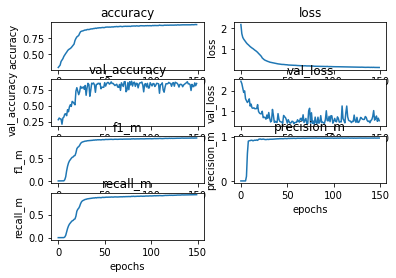

In [ ]:
plotmetrics(UCIhistory)

In [ ]:
def save_model_history(model,historypath,historymetric,modelpath):
  with open(historypath, 'wb') as file_pi:
          pickle.dump(historymetric.history, file_pi)
  model.save(modelpath+model_name[0])         

UCI LSTM_CNN

In [ ]:
UCI_LSTM_CNN = UCImodels['LSTM_CNN'].fit(UCIhalf_trainFFT, UCItrainY, epochs = 150, batch_size = 100, validation_data = (UCIhalf_valFFT, UCIvalY))

Epoch 1/150
87/87 [==============================] - 18s 110ms/step - loss: 1.6647 - accuracy: 0.2973 - f1_m: 0.0155 - precision_m: 0.0819 - recall_m: 0.0094 - val_loss: 1.3737 - val_accuracy: 0.3245 - val_f1_m: 0.1990 - val_precision_m: 0.3193 - val_recall_m: 0.1557
Epoch 2/150
87/87 [==============================] - 8s 87ms/step - loss: 1.1159 - accuracy: 0.4908 - f1_m: 0.3427 - precision_m: 0.5685 - recall_m: 0.2634 - val_loss: 1.1567 - val_accuracy: 0.5229 - val_f1_m: 0.5274 - val_precision_m: 0.6072 - val_recall_m: 0.4731
Epoch 3/150
87/87 [==============================] - 8s 88ms/step - loss: 0.8968 - accuracy: 0.6003 - f1_m: 0.5831 - precision_m: 0.6965 - recall_m: 0.5046 - val_loss: 0.8969 - val_accuracy: 0.6541 - val_f1_m: 0.6391 - val_precision_m: 0.7291 - val_recall_m: 0.5730
Epoch 4/150
87/87 [==============================] - 8s 89ms/step - loss: 0.7693 - accuracy: 0.6946 - f1_m: 0.6963 - precision_m: 0.7616 - recall_m: 0.6426 - val_loss: 0.8025 - val_accuracy: 0.7006 - 

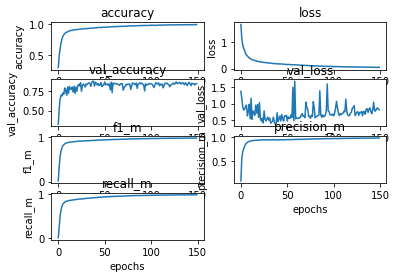

In [ ]:
plotmetrics(UCI_LSTM_CNN)

In [ ]:
save_model_history(UCImodels['LSTM_CNN'],'/content/drive/MyDrive/Datasets/UCI_HAPT_DATASET/UCI_LSTM_CNN_history',UCI_LSTM_CNN,
                   '/content/drive/MyDrive/Datasets/UCI_HAPT_DATASET/UCILSTM_CNN')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/UCI_HAPT_DATASET/UCILSTM_CNNLSTM_CNN_SANDWICH/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/UCI_HAPT_DATASET/UCILSTM_CNNLSTM_CNN_SANDWICH/assets


UCI ConvLSTM_PARALLEL

In [ ]:
UCI_ConvLSTM_PARALLEL = UCImodels['ConvLSTM_PARALLEL'].fit(UCIhalf_trainFFT, UCItrainY, epochs = 100, batch_size = 200, validation_data = (UCIhalf_valFFT, UCIvalY))

UCI GRU_CNN

In [ ]:
UCI_GRU_CNN = UCImodels['GRU_CNN'].fit(UCIhalf_trainFFT, UCItrainY, epochs = 100, batch_size = 200, validation_data = (UCIhalf_valFFT, UCIvalY))

Epoch 1/100
44/44 [==============================] - 32s 413ms/step - loss: 0.9069 - accuracy: 0.6694 - f1_m: 0.6424 - precision_m: 0.7686 - recall_m: 0.5674 - val_loss: 1.8336 - val_accuracy: 0.5826 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
44/44 [==============================] - 17s 387ms/step - loss: 0.4575 - accuracy: 0.8174 - f1_m: 0.8224 - precision_m: 0.8619 - recall_m: 0.7868 - val_loss: 1.4187 - val_accuracy: 0.6829 - val_f1_m: 0.1362 - val_precision_m: 0.9701 - val_recall_m: 0.0779
Epoch 3/100
44/44 [==============================] - 18s 403ms/step - loss: 0.3622 - accuracy: 0.8476 - f1_m: 0.8498 - precision_m: 0.8793 - recall_m: 0.8225 - val_loss: 1.3941 - val_accuracy: 0.5435 - val_f1_m: 0.3110 - val_precision_m: 0.5398 - val_recall_m: 0.2239
Epoch 4/100
44/44 [==============================] - 17s 393ms/step - loss: 0.3112 - accuracy: 0.8638 - f1_m: 0.8696 - precision_m: 0.8940 - recall_m: 0.8466 - val_loss: 1.2087 - val_a

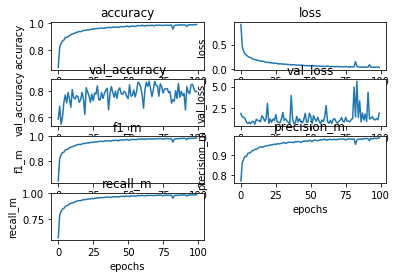

In [ ]:
plotmetrics(UCI_GRU_CNN)

In [ ]:
save_model_history(UCImodels['GRU_CNN'],'/content/drive/MyDrive/Datasets/UCI_HAPT_DATASET/UCI_GRU_CNN_history',UCI_GRU_CNN,
                   '/content/drive/MyDrive/Datasets/UCI_HAPT_DATASET/UCIGRU_CNN')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/UCI_HAPT_DATASET/UCIGRU_CNNLSTM_CNN_SANDWICH/assets


UCI CNN_GRU

In [ ]:
UCI_CNN_GRU = UCImodels['CNN_GRU'].fit(UCIhalf_trainFFT, UCItrainY, epochs = 100, batch_size = 200, validation_data = (UCIhalf_valFFT, UCIvalY))

Epoch 1/100
44/44 [==============================] - 22s 346ms/step - loss: 1.7343 - accuracy: 0.3442 - f1_m: 0.0490 - precision_m: 0.6838 - recall_m: 0.0257 - val_loss: 2.3466 - val_accuracy: 0.3466 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
44/44 [==============================] - 15s 337ms/step - loss: 1.3854 - accuracy: 0.3971 - f1_m: 0.0899 - precision_m: 0.6661 - recall_m: 0.0486 - val_loss: 2.2314 - val_accuracy: 0.3142 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/100
44/44 [==============================] - 14s 326ms/step - loss: 1.2752 - accuracy: 0.4197 - f1_m: 0.1612 - precision_m: 0.6918 - recall_m: 0.0930 - val_loss: 2.1483 - val_accuracy: 0.2382 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/100
44/44 [==============================] - 15s 333ms/step - loss: 1.2048 - accuracy: 0.4358 - f1_m: 0.2495 - precision_m: 0.6975 - recall_m: 0.1530 - 

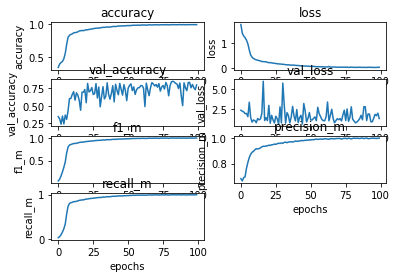

In [ ]:
plotmetrics(UCI_CNN_GRU)

In [ ]:
save_model_history(UCImodels['CNN_GRU'],'/content/drive/MyDrive/Datasets/UCI_HAPT_DATASET/UCI_CNN_GRU_history',UCI_CNN_GRU,
                   '/content/drive/MyDrive/Datasets/UCI_HAPT_DATASET/UCI_CNN_GRU')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/UCI_HAPT_DATASET/UCI_CNN_GRULSTM_CNN_SANDWICH/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/UCI_HAPT_DATASET/UCI_CNN_GRULSTM_CNN_SANDWICH/assets


Real World dataset model

In [ ]:
#'LSTM_CNN_SANDWICH','LSTM_CNN','ConvLSTM_PARALLEL','LSTM_CNN_PARALLEL','GRU_CNN','CNN_GRU'
#RealWorldhalf_trainFFT,RealWorldtrainY,RealWorldhalf_testFFT,RealWorldtestY,RealWorldhalf_valFFT,RealWorldvalY

In [ ]:
RWLSTM_CNN_SANDWICH = RealWorldmodels['LSTM_CNN_SANDWICH'].fit(RealWorldhalf_trainFFT, RealWorldtrainY, epochs = 100, batch_size = 200, validation_data = (RealWorldhalf_valFFT, RealWorldvalY))

Epoch 1/100
57/57 [==============================] - 32s 219ms/step - loss: 1.5073 - accuracy: 0.3755 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.5974 - val_accuracy: 0.4205 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
57/57 [==============================] - 10s 180ms/step - loss: 1.3646 - accuracy: 0.4168 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.5835 - val_accuracy: 0.4205 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/100
57/57 [==============================] - 10s 183ms/step - loss: 1.2816 - accuracy: 0.4793 - f1_m: 0.0027 - precision_m: 0.0074 - recall_m: 0.0017 - val_loss: 1.5709 - val_accuracy: 0.4205 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/100
57/57 [==============================] - 10s 180ms/step - loss: 1.1767 - accuracy: 0.5380 - f1_m: 0.0033 - precision_m: 0.06

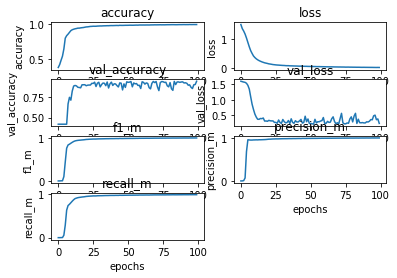

In [ ]:
plotmetrics(RWLSTM_CNN_SANDWICH)

In [ ]:
save_model_history(RealWorldmodels['LSTM_CNN_SANDWICH'],'/content/drive/MyDrive/Datasets/Real_world_Dataset/RWLSTM_CNN_SANDWICH_history',RWLSTM_CNN_SANDWICH,
                   '/content/drive/MyDrive/Datasets/Real_world_Dataset//RWLSTM_CNN_SANDWICH')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/Real_world_Dataset//RWLSTM_CNN_SANDWICHLSTM_CNN_SANDWICH/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/Real_world_Dataset//RWLSTM_CNN_SANDWICHLSTM_CNN_SANDWICH/assets


RealWorld LSTM CNN